In [1]:
# Program to find measure of expected significance as a function
# of a cut value x_cut applied to measured variable x
# by Monte Carlo simulation of the likelihood ratio statistic.
# G. Cowan / RHUL Physics / December 2022
# Performance improvements by L. Moureaux / UHH IExp / February 2025

import itertools as it
from multiprocessing import Pool

import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

In [2]:
#  Define pdfs and likelihood-ratio statisic
s_tot = 10.
b_tot = 100.
ps = s_tot/(s_tot+b_tot)
def f_s(x):
    return 3.*(1.-x)**2
def f_b(x):
    return 3.*x**2
def q(x):
    return -2.*np.log1p(s_tot / b_tot * f_s(x) / f_b(x))

In [3]:
def generate(s_tot, b_tot, seed, num):
    # Get a rng
    rng = np.random.default_rng(seed)

    # How many events do we get per toy?
    n_toy = np.random.poisson(s_tot + b_tot, num)

    # What's the total number of events in all toys?
    n_tot = n_toy.sum()

    # Randomly assign signal events
    ps = s_tot / (s_tot + b_tot)
    signal = np.random.choice(n_tot, int(ps * n_tot))

    # Generate x from uniform r in [0, 1]
    #  for background:  x = r^{1/3}
    #  for signal:      x = 1 - r^{1/3}
    # Use float32 for efficiency
    x = rng.random(n_tot, dtype=np.float32)
    x **= 1 / 3
    x[signal] = 1 - x[signal]

    # Ignore divide-by-zero errors caused by arithmetic precision.
    with np.errstate(divide='ignore'):
        # Compute the test statistic for all events
        q_ = q(x)

    # Sum for each toy
    return np.add.reduceat(q_, np.cumsum(n_toy) - 1)

def parallel_generate(s_tot, b_tot, seeds, num, batch_size=10_000):
    batches = (num + batch_size - 1) // batch_size
    
    # https://numpy.org/doc/stable/reference/random/parallel.html#seedsequence-spawning
    seeds = seeds.spawn(batches)

    # Arguments for each batch
    args = zip(it.repeat(s_tot), 
               it.repeat(b_tot),
               seeds,
               it.repeat(batch_size))

    q = Pool().starmap(generate, args)

    return np.concatenate(q)[:num]

In [4]:
# Generate data under b and s+b hypotheses
numExp = 10_000_000

seeds = np.random.SeedSequence(123456)

qb = parallel_generate(0, b_tot, seeds, numExp)
qsb = parallel_generate(s_tot, b_tot, seeds, 100_000)  # We never need as many toys for qsb

In [5]:
med_q_sb = np.median(qsb)
print("median[q|s+b]   = {:.3f}".format(med_q_sb))

median[q|s+b]   = -41.182


Text(0, 0.5, '$f(q)$')

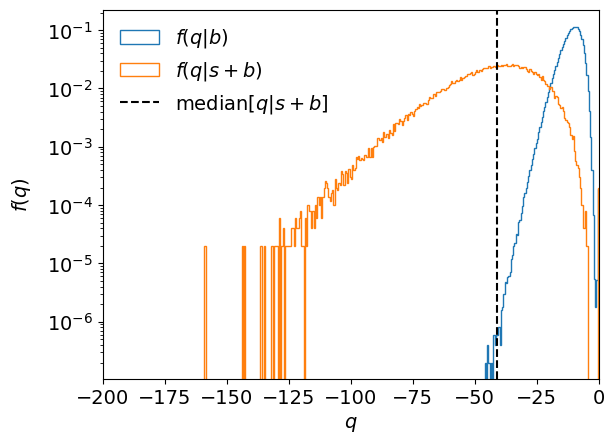

In [6]:
# Plot histograms of q
hist_range = -200, 0
bins = 400

plt.hist(qb, range=hist_range, bins=bins, histtype='step', density=True, label=r'$f(q|b)$')
plt.hist(qsb, range=hist_range, bins=bins, histtype='step', density=True, label=r'$f(q|s+b)$')

plt.axvline(med_q_sb, color="black", linestyle="dashed", label = r'median$[q|s+b]$')

plt.legend(loc='upper left', frameon=False)

plt.xlim(*hist_range)
plt.xlabel(r'$q$', labelpad=5)

plt.yscale("log")
plt.ylabel(r'$f(q)$', labelpad=10)

In [7]:
# Add code to calculate the p-value of the b-only hypothesis
# for the median q from data generated according to s+b.
# Find the corresponding significance Z.

In [8]:
stat = (qb < med_q_sb).sum()
print(f'Number of toys passing the median = {stat}')
pval = (qb < med_q_sb).mean()
print(f'Expected p-value = {pval}')
significance = stats.norm.isf(pval)
print(f'Expected significance = {significance}')

Number of toys passing the median = 80
Expected p-value = 8e-06
Expected significance = 4.314451021808664
